In [1]:
%matplotlib notebook

In [2]:
import pandas as pd
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def read_bs(fili):
    """
    Reads text file containing Bering Strait flux data into Pandas DataFrame
    """
    df = pd.read_csv(os.path.join(diri, fili), header=None, comment='%',sep='\s+', 
                 names=['Mooring', 'Year', 'Month', 'Mean', 'Error', 'MeanCorr', 'CorrErr'],
                 parse_dates={'time': ['Year', 'Month']}, index_col='time')
    return df

## Read Bearing Strait heat flux and convert to DataArray

In [6]:
diri = r'C:\Users\apbarret\Documents\data\BeringStraitHeatFlux'
#diri = '/home/apbarret/data/BeringStraitHeatFlux/Mooring'
fili = r'BeringStrait_Monthlymeans_TRANSPORT_Oct2017.txt'

df = read_bs(os.path.join(diri, fili))
transport = xr.DataArray.from_series(df['MeanCorr'])

<IPython.core.display.Javascript object>


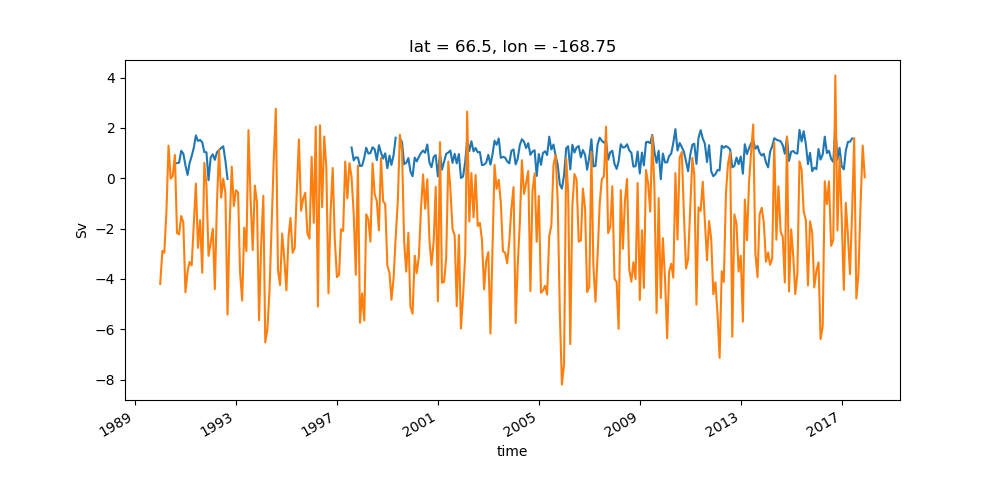

Text(0,0.5,'Sv')

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
transport.plot(ax=ax)
ax.set_title('Bearing Strait Transport Flux')
ax.set_ylabel('Sv')

## Get winds

In [10]:
reanalysis_dir = diri
#reanalysis_dir = '/disks/arctic5_raid/abarrett/MERRA2/monthly'
ncfile = 'MERRA2_400.instM_2d_asm_Nx.U10M.month.1980to2018.nc4'
u10m = xr.open_dataset(os.path.join(reanalysis_dir, ncfile))
u10m = u10m['U10M'].loc[dict(time=slice('1990-01-01','2017-12-01'), lat=slice(20,90))]

reanalysis_dir = diri
#reanalysis_dir = '/disks/arctic5_raid/abarrett/MERRA2/monthly'
ncfile = 'MERRA2_400.instM_2d_asm_Nx.V10M.month.1980to2018.nc4'
v10m = xr.open_dataset(os.path.join(reanalysis_dir, ncfile))
v10m = v10m['V10M'].loc[dict(time=slice('1990-01-01','2017-12-01'), lat=slice(20,90))]

print (u10m)
print (v10m)

<xarray.DataArray 'U10M' (time: 336, lat: 141, lon: 576)>
[27288576 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 20.0 20.5 21.0 21.5 22.0 22.5 23.0 23.5 24.0 24.5 ...
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 -177.5 -176.9 -176.2 ...
  * time     (time) datetime64[ns] 1990-01-01 1990-02-01 1990-03-01 ...
Attributes:
    long_name:     10-meter_eastward_wind
    units:         m s-1
    vmax:          999999987000000.0
    vmin:          -999999987000000.0
    valid_range:   [-9.99999987e+14  9.99999987e+14]
    origname:      U10M
    fullnamepath:  /U10M
<xarray.DataArray 'V10M' (time: 336, lat: 141, lon: 576)>
[27288576 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 20.0 20.5 21.0 21.5 22.0 22.5 23.0 23.5 24.0 24.5 ...
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 -177.5 -176.9 -176.2 ...
  * time     (time) datetime64[ns] 1990-01-01 1990-02-01 1990-03-01 ...
Attributes:
    long_name:     10-meter_northward_wind
    uni

## Rotate winds relative to 330 deg. N

I use affine for this.  Affine.rotation returns a rotation matrix.  This can then be used to post-multiply a tuple of u and v winds

In [11]:
from affine import Affine

relative_wind_direction = 330.
fwd = Affine.rotation(relative_wind_direction)
u10m_rot, v10m_rot = (u10m, v10m)*fwd

## Find cell closest to A3 mooring

In [14]:
a3_lat=66.338; a3_lon=-168.968
a3_v10m_rot = v10m_rot.sel(lat=a3_lat, lon=a3_lon, method='nearest')
a3_v10m_rot.plot()

## Plot A3 near-surface winds against transport

<IPython.core.display.Javascript object>


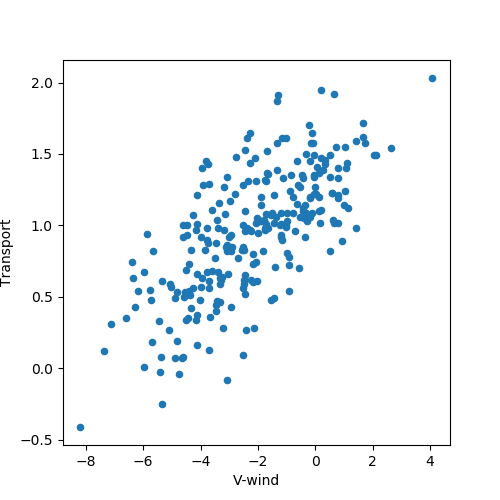

In [27]:
#df = pd.DataFrame(transport.to_dataframe()})
df = transport.to_dataframe(name='Transport')
df['V-wind'] = a3_v10m_rot

fig, ax = plt.subplots(figsize=(5,5))

df.plot.scatter(x='V-wind', y='Transport', ax=ax)
#ax.set_aspect('equal')

## Calculate regression

<IPython.core.display.Javascript object>


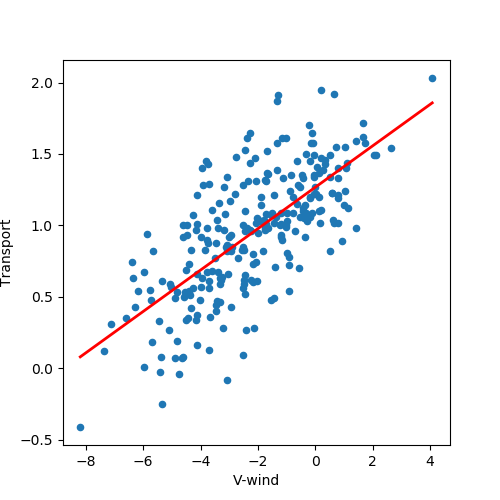

In [67]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
x = df.dropna()['V-wind'].values.reshape(-1,1)
y = df.dropna()['Transport'].values.reshape(-1,1)
lm.fit(x, y)
yhat = lm.predict(x).reshape(-1)

fig, ax2 = plt.subplots(figsize=(5,5))

df.plot.scatter(x='V-wind', y='Transport', ax=ax2)

yhat = lm.coef_*np.array([x.min(),x.max()]) + lm.intercept_
ax2.plot(np.array([x.min(),x.max()]), yhat.reshape(-1), 'r', lw=2)

In [52]:
lm.coef_

array([[0.14491366]], dtype=float32)

In [56]:
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
y = np.dot(X, np.array([1,2])) + 3
y

array([ 6,  8,  9, 11])

## Calculate correlation coeficient
I haven't figured out how to do this in one fell swoop, so I do it in several steps.
1. Calculate anomaly time series in time dimensions for U10M and heat flux
2. Calculate gridcell covariances between the two data sets
3. Calculate standard deviations for the two data sets
4. Calculate correlation coeficients for each grid cell

### Step 0.  Remove months with missing data (NaNs)

In [8]:
heat = heat.dropna(dim='time')
v10m_rot = v10m_rot.where(xr.ufuncs.isfinite(heat), drop=True)

### Step 1.  Calculate anomaly time series

In [9]:
def anomaly(x, dim=None):
    return x - x.mean(dim=dim)

In [10]:
heatAnom = heat.groupby('time.month').apply(anomaly)
v10m_rotAnom = v10m_rot.groupby('time.month').apply(anomaly, dim='time')

### Step 2. Calculate covariance

In [11]:
cov = (v10m_rotAnom * heatAnom).groupby('time.month').mean(dim='time')

### Step 3. Calculate standard deviations

In [12]:
heatStd = heat.groupby('time.month').std(dim='time')
v10m_rotStd = v10m_rot.groupby('time.month').std(dim='time')

In [13]:
print (cov.shape)
print (heatStd.shape)
print (v10m_rotStd.shape)

(12, 141, 576)
(12,)
(12, 141, 576)


### Step 4. Calculate correlation coeficient

In [14]:
corrcoef = cov / (heatStd * v10m_rotStd)

In [15]:
from scipy import stats

# calculate t-statistic
n = heat.groupby('time.month').count()
dgf = np.sqrt(n - 2)
den = np.sqrt(1 - (corrcoef*corrcoef))
t = corrcoef*dgf / den

p = 1 - stats.t.cdf(np.abs(t), 21)
r = corrcoef.where(2*p < 0.05)

## Plot results

In [16]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl

In [17]:
r

<xarray.DataArray (month: 12, lat: 141, lon: 576)>
array([[[-0.584411, -0.587674, ..., -0.580205, -0.580985],
        [-0.577514, -0.582756, ..., -0.571228, -0.573173],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,      

<IPython.core.display.Javascript object>


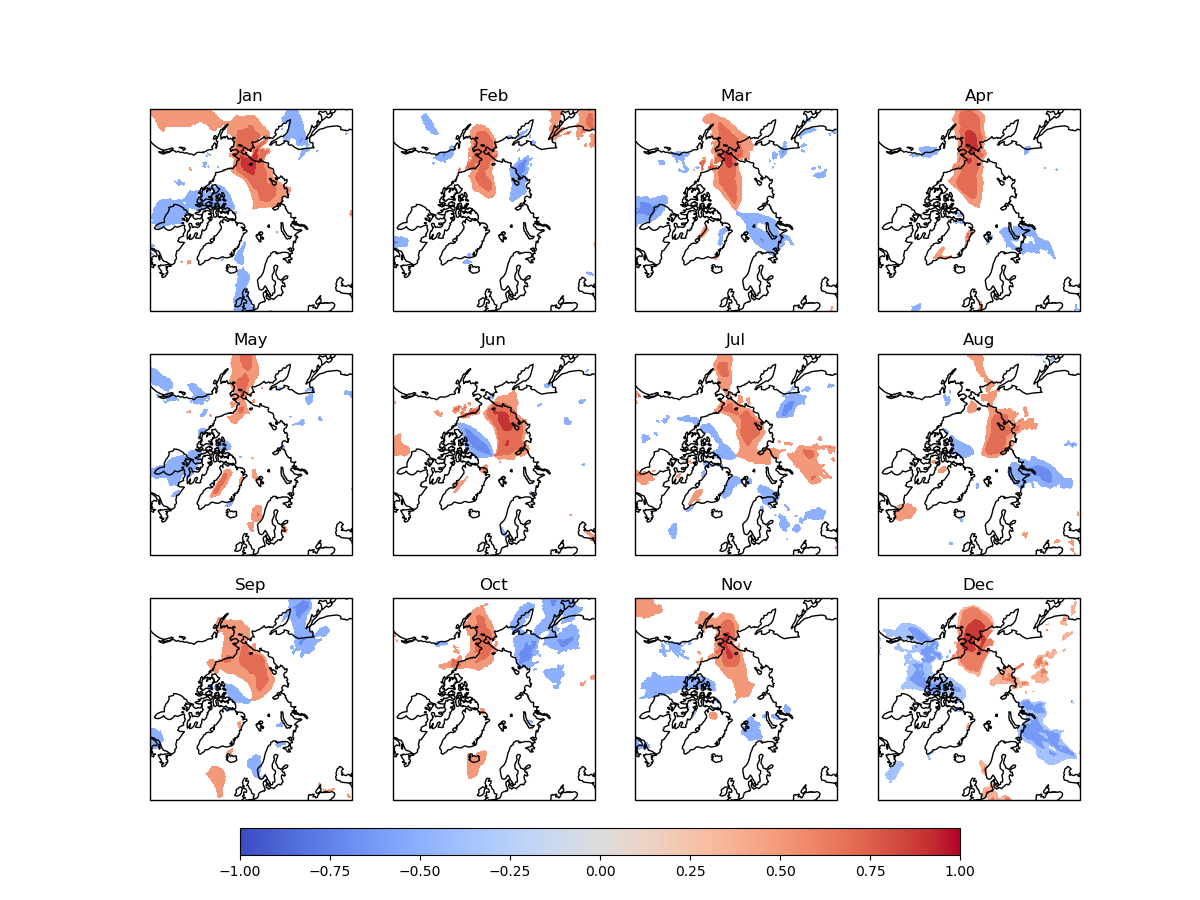

In [18]:
fig = plt.figure(figsize=(12, 9))

land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor=0.5)

cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=-1., vmax=1.)

ax = []
monthstr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i, mstr in enumerate(monthstr):
        
    ax.append( plt.subplot(3, 4, i+1, projection=ccrs.NorthPolarStereo()) )
    
    ax[i].set_extent([-180.,180.,50.,90.], ccrs.PlateCarree())
    #cax = r.isel(month=i).plot(ax=ax[i], transform=ccrs.PlateCarree(), add_colorbar=False, 
    #                           norm=norm, cmap=cmap)
    ax[i].contourf(r.lon, r.lat, r.isel(month=i), transform=ccrs.PlateCarree(), 
                    norm=norm, cmap=cmap)
    ax[i].coastlines()
    #ax[i].add_feature(land, zorder=1)
    ax[i].set_title(mstr)

axc = fig.add_axes([0.2, 0.05, 0.6, 0.03])
cbar = mpl.colorbar.ColorbarBase(axc, orientation='horizontal', norm=norm, cmap=cmap)

fig.savefig(os.path.join(diri,'MERRA2_V10M_BSTrans_Correlation_Month_rot330.png'))
#ax.add_feature(cfeature.LAND, zorder=1, facecolor=0.3)